_Napolitano Daniele, Master’s Degree in Artificial Intelligence, University of Bologna_
# <b>Bayesify</b>
# A personal music taste analysis using Bayesian Networks
### <b>Abstract</b>
Modern streaming platforms are known for their ability to predict the preferences of their users. The music industry in particular poses a complex challenge due to the vastness of different music genres and songs available. \\
This project aims to model a Bayeian Network from a dataset built by fetching Spotify's API personal data, to experiment with different queries and methods in order to find interesting relationships. Finally, a use case scenario with the final model is presented.
This dataset will be analyzed using Bayesian Networks, trying to build a good model with causal relationship between the features of the dataset, and making inference with different methods.<br>
### <b>Table of Contents</b>
1. [Domain](#1-domain)
    - 1.1 [Dataset analysis](#11-dataset-analysis)
2. [Model Creation](#2-model-creation)
    - 2.1 [Using domain knowledge](#21-using-domain-knowledge)
    - 2.2 [Learning the structure](#22-learning-bayesian-network-structure)
    - 2.3 [Comparing the two models](#23-comparing-the-two-models)
3. [Network Analysis](#3-network-analysis)  
    - 3.1 [CPD](#31-cpd)
    - 3.2 ["like" ancestral graph](#32-parents-of-like)
4. [Inference](#4-inference)
    - 4.1 [Genre](#41-genre)
    - 4.2 [Like](#42-like)
5. [Use Case Scenario](#5-use-case-scenario)
6. [Conclusion](#6-conclusion)

_[References](#references)_

## <b>1. Domain</b><a class="anchor" id=1-domain></a>
I've made a tataset with 300 songs I like and 300 i dislike (and commented the whole process in the file [Dataset.ipynb](https://github.com/danielenapo/Bayesify/blob/main/Dataset.ipynb)).<br>
First, the dataset is imported.

In [3]:
import pgmpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#remove warnings
import warnings
warnings.filterwarnings('ignore')
#import dataset
data=pd.read_csv("spotifyData.csv")
data=data.drop(data.columns[0],axis=1)
genre_dict = { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}


c:\Users\gnele\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following is a brief description of the meaning of the features in the dataset, taken by the official Spotify's API documentation page $^{[1]}$:
<i>
- <b>like</b><br>
Binary value, 1 if I like the song, 0 otherwise.
- <b>genre</b><br>
The main genre of the artist, mapped into the following dictionary:
> { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}

- <b>danceability</b><br>
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0 is least danceable and 4 is most danceable.
- <b>energy</b><br>
Energy is a measure from 0 to 4 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- <b>loudness</b><br>
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db, but were mapped from 0 to 4.
- <b>acousticness</b><br>
A confidence measure from 0 to 4 of whether the track is acoustic. 4 represents high confidence the track is acoustic.
- <b>instrumentalness</b>:<br>
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". It's a binary value where 1 indicates that the song is probably instrumental, 0 otherwais.
- <b>valence</b><br>
A measure from 0 to 4 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- <b>tempo</b><br>
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
</i>

### <b>1.1 Dataset analysis</b><a class="anchor" id="11-dataset-analysis"></a>
To give some contest, below it's a graph showing the genres present in the dataset, divided by like/dislike

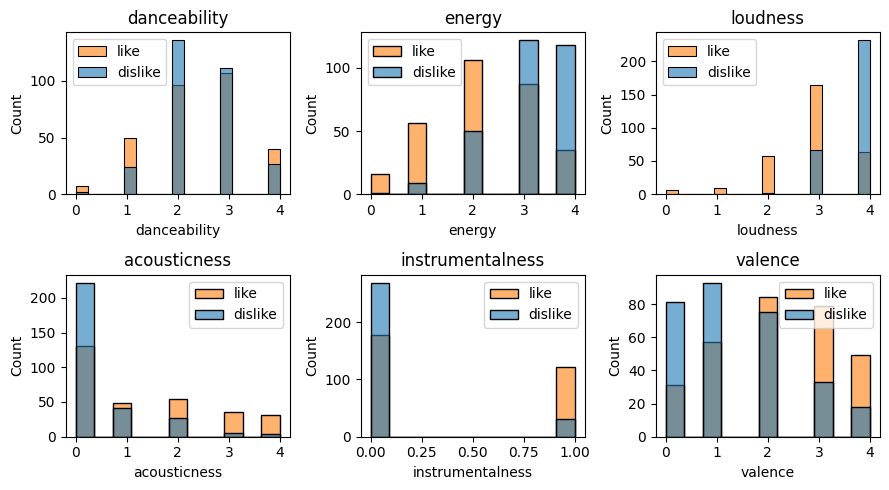

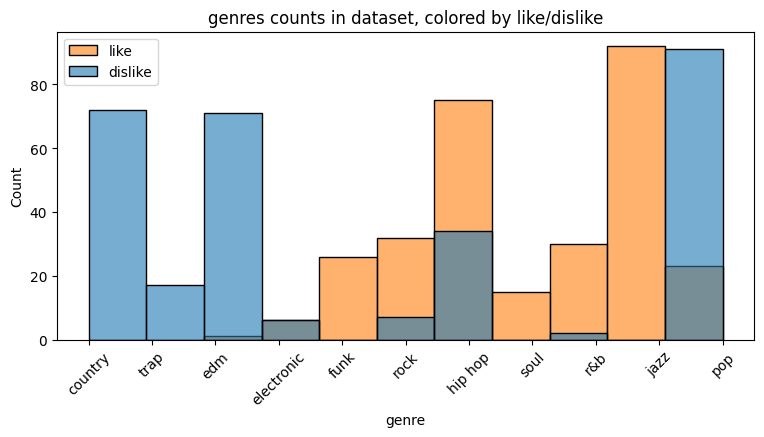

In [4]:
#show histogram of all features in a single plot, hue=like
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
for i, ax in enumerate(axes.flat):
    sns.histplot(data=data, x=data.columns[i], hue='like', ax=ax, color=['red','blue'], alpha=0.6)
    ax.set(title=data.columns[i])
    ax.legend(['like','dislike'])
plt.tight_layout()
plt.show()
#histogram of genres
plt.figure(figsize=(9,4))
sns.histplot(data=data,x='genre',hue='like', alpha=0.6)
plt.xticks(np.arange(1,12),genre_dict.values(),rotation=45)
plt.title('genres counts in dataset, colored by like/dislike')
plt.legend(['like','dislike'])
plt.show()

## <b>2. Model Creation </b> <a class="anchor" id="2-model-creation"></a>
### <b>2.1 Using domain knowledge </b> <a class="anchor" id="21-using-domain-knowledge"></a>

The model topology was made from the domain knowledge (given by the features description), the correlation analysis, and via trial and error

In [5]:
from pgmpy.models import BayesianNetwork
from pgmpy.base import DAG

custom_dag=DAG([('genre', 'like'), ("instrumentalness", "genre"), ("acousticness", "loudness"), ("loudness", "energy"), ("energy", "valence"),
            ("tempo", "danceability"), ("loudness", "genre"), ("danceability", "valence")])
custom_model = BayesianNetwork([('genre', 'like'), ("instrumentalness", "genre"), ("acousticness", "loudness"), ("loudness", "energy"), ("energy", "valence"),
            ("tempo", "danceability"), ("loudness", "genre"), ("danceability", "valence")])

We want to automatically learn the parameters for the `CPDs (Conditional Probability Distributions)` of the model, by analyzing the dataset with `Maximum Likelihood Estimation (MLE)`.<br>

In [6]:
from pgmpy.estimators import MaximumLikelihoodEstimator
custom_model.fit(data, estimator=MaximumLikelihoodEstimator)

The graph below represents the network:

{'genre': [0.25, 0.5], 'like': [0.25, 0.05], 'instrumentalness': [0.27, 0.3], 'acousticness': [0.31, 0.79], 'loudness': [0.28, 0.85], 'energy': [0.31, 0.55], 'valence': [0.33, 0.35], 'tempo': [0.3, 0.1], 'danceability': [0.33, 0.1]}


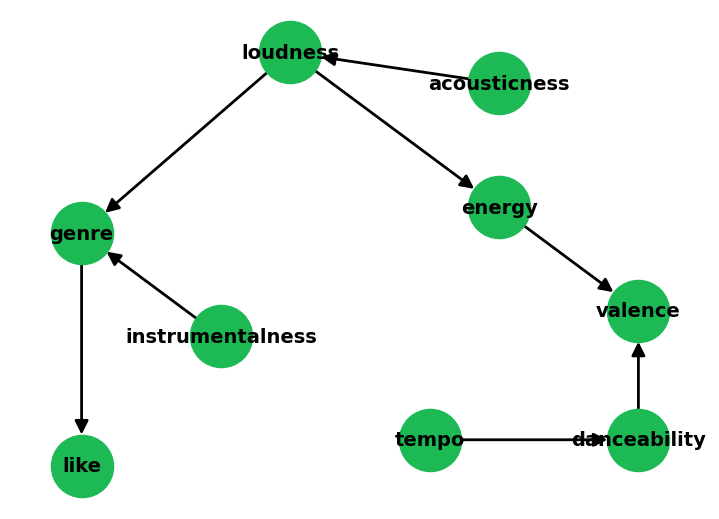

In [7]:
import networkx as nx
def print_network(model, pos):
    nx_graph = nx.DiGraph(model.edges())
    plt.figure(figsize=(7,5))
    nx.draw(nx_graph, with_labels=True, node_color='#1DB954', node_size=2000, alpha=1, arrowsize=20, font_size=14, font_weight='bold', pos=pos, width=2)
    print(pos)
    plt.show()
custom_pos= {'genre': [0.25, 0.5], 'like': [0.25, 0.05], 'instrumentalness': [0.27, 0.3], 'acousticness': [0.31, 0.79], 'loudness': [0.28, 0.85], 'energy': [0.31, 0.55], 
          'valence': [0.33, 0.35], 'tempo': [0.3, 0.1], 'danceability': [0.33, 0.1]}
print_network(custom_model, custom_pos)

### <b>2.2 Learning Bayesian Network structure </b> <a class="anchor" id="22-learning-bayesian-network-structure"></a>
Using hill climb search and BDeu Score, the network structure is learned automatically.


{'genre': [0.275, 0.5], 'like': [0.25, 0.1], 'instrumentalness': [0.35, 0.4], 'acousticness': [0.3, 0.75], 'loudness': [0.25, 0.85], 'energy': [0.4, 0.8], 'valence': [0.48, 0.7], 'tempo': [0.4, 0.2], 'danceability': [0.45, 0.5]}


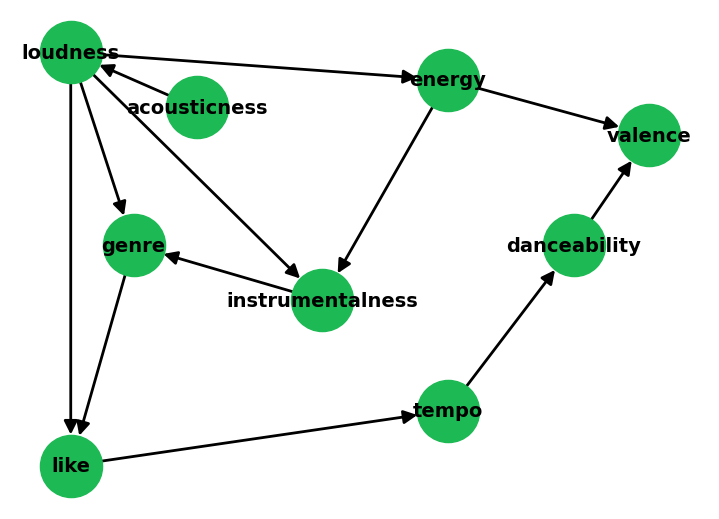

In [8]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
#create dag instance from custom_model

#hill climb search
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BDeuScore(data), show_progress=False,  fixed_edges=custom_dag.edges )
#fit model and print
hc_model=BayesianNetwork(best_model.edges())
hc_model.fit(data, estimator=MaximumLikelihoodEstimator)
hc_pos= {'genre': [0.275, 0.5], 'like': [0.25, 0.1], 'instrumentalness': [0.35, 0.4], 'acousticness': [0.3, 0.75], 'loudness': [0.25, 0.85], 'energy': [0.4, 0.8], 
          'valence': [0.48, 0.7], 'tempo': [0.4, 0.2], 'danceability': [0.45, 0.5]}
print_network(best_model, hc_pos)


This new model has more links than the previous one (hence is more complex). Some links are the same (for example genre is linked to lige, and instrumentalness to genre), but there is a problem of causality: "like" is connected to tempo. This makes no sense semantically, because the tempo of a song is totally independent from the fact that I like it or not, but it could be the other way around.<br> In general, like should not lead to anything.


## <b>3. Network analysis</b> <a class="anchor" id="3-network-analysis"></a>
PGMpy provides lots of methods to analyze and evaluate Bayesian Networks.<br>
In this section, the two models are analyzed in different ways, to better understand their topology and differences.


### <b>3.1 Comparing the two models</b> <a class="anchor" id="31-comparing-the-two-models"></a>
Let's compare the BDeu scores of both models:


In [9]:
from pgmpy.estimators import BDeuScore
print("BDeuScore for custom model: ", BDeuScore(data).score(custom_model))
print("BDeuScore for hill-climb search model: ", BDeuScore(data).score(hc_model))

BDeuScore for custom model:  -6439.986396841089
BDeuScore for hill-climb search model:  -6334.668699660097


Even if the values are almost equivalent, we get that the hill-climb model is slightly worse. This does not necessarely mean that the second model is worse, because BDeu score tends to prefer simpler models.
### <b>3.2 CPD</b> 


In [21]:
cpdLike=pd.DataFrame(custom_model.get_cpds("like").values)
cpdLike.columns=genre_dict.values()
print("CPD for like, custom model: ")
cpdLike

CPD for like, custom model: 


,country,trap,edm,electronic,funk,rock,hip hop,soul,r&b,jazz,pop
0,1.0,1.0,0.986111,0.5,0.0,0.179487,0.311927,0.0,0.0625,0.0,0.798246
1,0.0,0.0,0.013889,0.5,1.0,0.820513,0.688073,1.0,0.9375,1.0,0.201754


In [34]:
print("CPD for like, hill-climb search model: ")
print(hc_model.get_cpds("like"))


CPD for like, hill-climb search model: 
+----------+---------------+-----+---------------------+
| genre    | genre(1)      | ... | genre(11)           |
+----------+---------------+-----+---------------------+
| loudness | loudness(0.0) | ... | loudness(4.0)       |
+----------+---------------+-----+---------------------+
| like(0)  | 0.5           | ... | 0.8974358974358975  |
+----------+---------------+-----+---------------------+
| like(1)  | 0.5           | ... | 0.10256410256410256 |
+----------+---------------+-----+---------------------+


For the HC model, like depends on loudness other than genre, so the CPD has 3 dimensions. For this reason it was represented whit PGMpy's `TabularCPD` class, which is more suitable for this kind of CPD.


### <b>3.3 Ancestral graphs for "like"</b>
The following graph shows the parents of the "like" node, in the two models. 

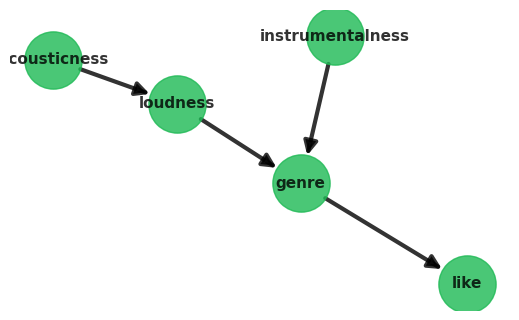

In [13]:
ancestral_graph_like=custom_model.get_ancestral_graph("like")
nx_graph2 = nx.DiGraph(ancestral_graph_like.edges())
plt.figure(figsize=(5,3))
nx.draw(nx_graph2, with_labels=True, node_color='#1DB954', node_size=1700, alpha=0.8, arrowsize=20, font_size=11, font_weight='bold', width=3)
plt.show()

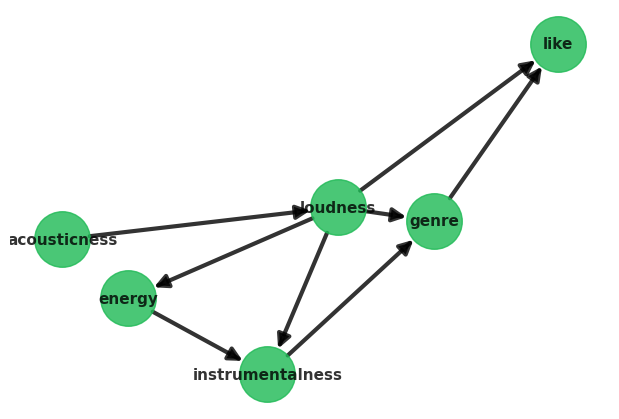

In [14]:
ancestral_graph_like=hc_model.get_ancestral_graph("like")
nx_graph2 = nx.DiGraph(ancestral_graph_like.edges())
plt.figure(figsize=(6,4))
nx.draw(nx_graph2, with_labels=True, node_color='#1DB954', node_size=1600, alpha=0.8, arrowsize=20, font_size=11, font_weight='bold', width=3)
plt.show()


### <b> 3.4 Sampling </b> <a class="anchor" id="34-sampling"></a>
For reasons that will become clear in the next section, we want to sample from the model. We can do this using the `sample` method of the `BayesianModel` class.<br> 
The following code samples 10000 instances from the model, where the evidence is like=1, and the variable is "genre".<br>

In [35]:
#sampling
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
infer_appr=BayesianModelSampling(custom_model)
q_appr=infer_appr.rejection_sample(evidence= [State('like', 1)], size=10000, show_progress=False)
for i in np.unique(q_appr["genre"]):
    print(i, genre_dict[i], ":",q_appr.value_counts('genre')[i])

4 electronic : 5
5 funk : 349
6 rock : 1091
7 hip hop : 2446
8 soul : 272
9 r&b : 896
10 jazz : 2147
11 pop : 2794


## <b>4. Inference</b> <a class="anchor" id="4-inference"></a>
Different queries are performed to infer the probability of certain features. Then, for each of them, different models/methods are tested and compared.<br>
Below is a function responsible of plotting a histogram of the results.


In [15]:
def plot_inference(queries, target, model, size=(10,5)):
    plt.figure(figsize=size)
    df=pd.DataFrame(columns=[target,'probability', 'model'])

    for q,m in zip(queries, model):
        #get the number of states for the target variable
        n_var=q.get_cardinality([target])[target]
        for i in range(n_var):
            name=q.get_state_names(target, state_no=i)
            if target=='genre':
                name=genre_dict[name]
            df=df.append({target:name, 'probability':q.values[i], "model":m},ignore_index=True)
    sns.barplot(x=target,y='probability',data=df, hue="model")

### <b>4.1. Genre</b> <a class="anchor" id="41-genre"></a>
We want to know the probability of a song to be of a certain genre, changing the evidence.
### $P(genre|like=1)$

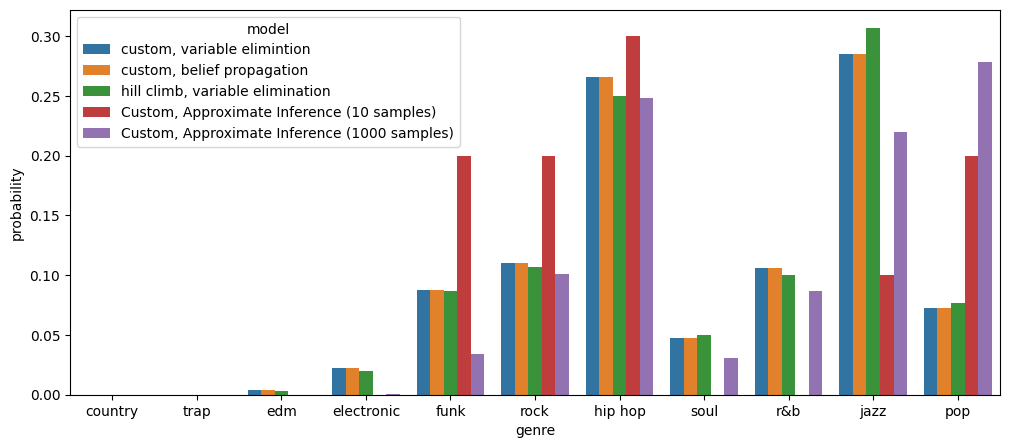

In [16]:
# make inference
from pgmpy.inference import VariableElimination
from pgmpy.inference import ApproxInference
from pgmpy.inference import BeliefPropagation

evidence={"like":1}
var=['genre']

#custom Variable elimination
infer_custom_ve=VariableElimination(custom_model)
q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
#custim belief propagation
infer_custom_bp=BeliefPropagation(custom_model)
q_custom_bp = infer_custom_bp.query(variables=var, evidence=evidence)
#hill climb
infer_hc=VariableElimination(hc_model)
q_hc= infer_hc.query(variables=var, evidence=evidence)
#approximate inference 10 samples
infer_appr=ApproxInference(custom_model)
q_appr=infer_appr.query(variables=var, evidence=evidence, n_samples=10, show_progress=False)
#approximate inference 1000 samples
q_appr2=infer_appr.query(variables=var, evidence=evidence, n_samples=1000, show_progress=False)
plot_inference([q_custom_ve,q_custom_bp,q_hc, q_appr, q_appr2], 'genre', 
               ['custom, variable elimintion', "custom, belief propagation",'hill climb, variable elimination', "Custom, Approximate Inference (10 samples)", "Custom, Approximate Inference (1000 samples)"], size=(12,5))



As we can see, the results are similar to the distribution of genre by like, but the probability of pop is higher than expected for approximate inference.  Using a higher number of sampls gives more extreme results.<br>
NOTE: PGMpy uses Rejection Sampling when performing approximate inference $^{[1]}$ (when evidence is provided, like in this case).
The problem is on the sampling.<br>

### $P(loudness|genre)$, for each genre
Comparing result using variable elimination, for the custom and the hill-climb model.

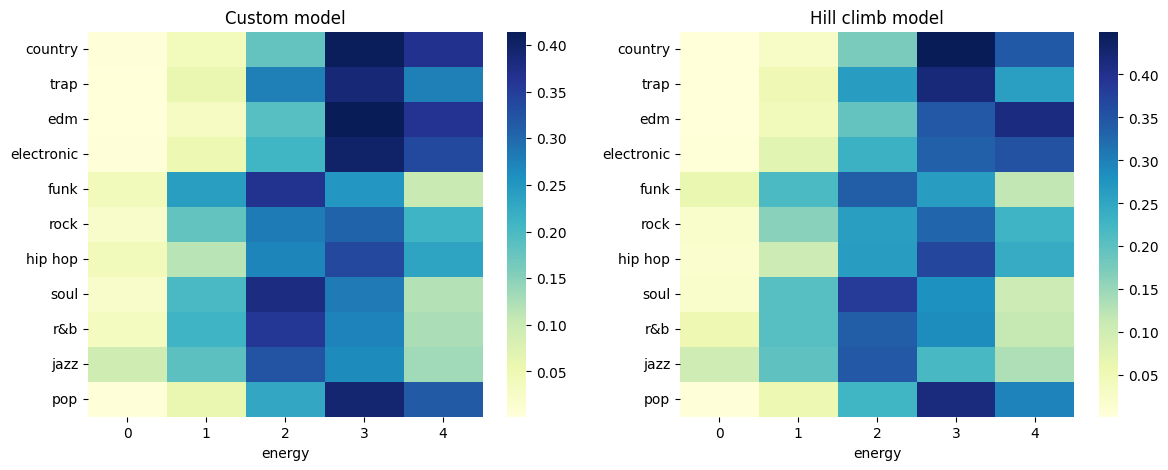

In [17]:
var=['energy']
results=[]
results2=[]
for i in genre_dict.keys():
    evidence={"genre":i}
    #custom
    infer_custom_ve=VariableElimination(custom_model)
    q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
    results.append(q_custom_ve.values)
    #hc
    infer_hc=VariableElimination(hc_model)
    q_hc= infer_hc.query(variables=var, evidence=evidence)
    results2.append(q_hc.values)
# heatmap plot where x is genre, y is energy, and color is probability
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Custom model")
sns.heatmap(results, xticklabels=np.arange(5), yticklabels=genre_dict.values(), cmap="YlGnBu")
plt.xlabel(var[0])
plt.subplot(1,2,2)
plt.title("Hill climb model")
sns.heatmap(results2, xticklabels=np.arange(5), yticklabels=genre_dict.values(), cmap="YlGnBu")
plt.xlabel(var[0])
plt.show()



The results are similar, if not almost identical.

## <b>4.2 Like</b> <a class="anchor" id="42-like"></a>

Now let's see the probability of like, given all the other features.

Text(0.5, 1.0, "Inference for 'like'")

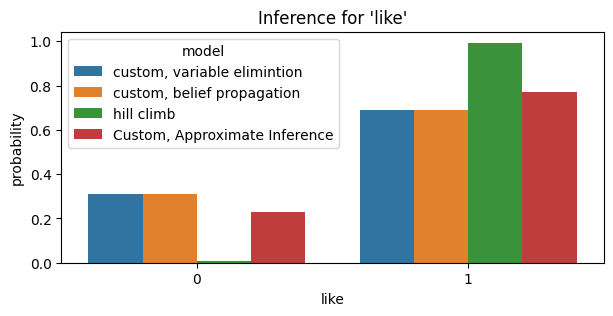

In [18]:
evidence={'danceability': 1.0, 'energy': 1.0, 'acousticness': 4.0, 'instrumentalness': 0, 'valence': 0.0, 'tempo': 4.0, 'genre': 7.0} 
var=['like']
#custom Variable elimination
infer_custom_ve=VariableElimination(custom_model)
q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
#custim belief propagation
infer_custom_bp=BeliefPropagation(custom_model)
q_custom_bp = infer_custom_bp.query(variables=var, evidence=evidence)
#hill climb
infer_hc=VariableElimination(hc_model)
q_hc= infer_hc.query(variables=var, evidence=evidence)
#approximate inference
infer_appr=ApproxInference(custom_model)
q_appr=infer_appr.query(variables=var, evidence=evidence, n_samples=100, show_progress=False)
plot_inference([q_custom_ve,q_custom_bp,q_hc, q_appr], 'like', ['custom, variable elimintion', "custom, belief propagation",'hill climb', "Custom, Approximate Inference"], size=(7,3))
plt.title("Inference for 'like'")


This time, approximate inference took much longer to sample the results, but gave similar results to the exact inferences. Belief propagation still gave the same results as variable elimination.<br>


Now, we want to examine how much the genre impacts the results: We are going to use the Exact Inference method on the custom model. The other features unchanged.


Text(0.5, 1.0, 'Inference with and without genre')

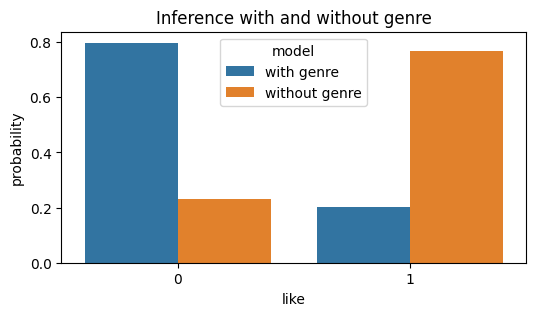

In [19]:
evidence1={'danceability': 1.0, 'energy': 1.0, 'acousticness': 4.0, 'instrumentalness': 0, 'valence': 0.0, 'tempo': 4.0, 'genre': 11.0} 
evidence2={'danceability': 1.0, 'energy': 1.0, 'acousticness': 4.0, 'instrumentalness': 0, 'valence': 0.0, 'tempo': 4.0}
#with genre
infer_custom_ve=VariableElimination(custom_model)
q1 = infer_custom_ve.query(variables=var, evidence=evidence1)
#without genre
q2 = infer_custom_ve.query(variables=var, evidence=evidence2)
plot_inference([q1,q2], 'like', ['with genre', "without genre"], size=(6,3))
plt.title("Inference with and without genre")



## <b>5. Use case scenario</b> <a class="anchor" id="5-use-case-scenario"></a>
After all the analysis, we can now apply the knowledge gained with the experiments to prototype a use case  .<br>
Given a song name and artist, the model will predict if I like it or not, returning the probability (as a mean of the results of the two models), while showing different informations about the song.
<br>
This mimics what Spotify does when evaluating if a song is a good match for a user, based on the user's listening history (but of course it's much more complex than that).

For some artists, genre is not available, but the model will still be able to make inference based on the other features.


In [20]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer


sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri="http://localhost:8888/callback"))

def preprocessing(track_features):
    #read raw data, remove like and genre column
    rawData=pd.read_csv("RawData.csv")
    rawData=rawData.drop(["like", "genre"], axis=1)
    if 'genre' in rawData.columns:
        rawData=rawData.drop(["genre"], axis=1)
    df=(pd.DataFrame(track_features))
    df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
    # scale data with minmaxscaler
    scaler = MinMaxScaler()
    rawData=rawData.append(df, ignore_index=True)   #add df to rawData as last entry                
    rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']] = scaler.fit_transform(rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']])
    # discretization using KBinsDiscretizer
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']] = est.fit_transform(rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']])
    rawData['instrumentalness']= rawData["instrumentalness"].apply(lambda x: 1 if x>0.25 else 0)
    #return final dataframe
    df=rawData.tail(1)
    rawData=0
    df=df.drop(df.columns[0], axis=1)
    return df

def enumerate_genre(genres):
    g=0
    for genre in genres:
        for key, value in genre_dict.items():
            if value in genre:
                g = key
        if g!=0:
            break
    return g

#function to get the track features from spotify given song name and artist
def retrieve_song(song_name, artist_name, verbose=False):
    #get the track id
    track_id = sp.search(q='track:' + song_name + ' artist:' + artist_name, type='track')
    track_id = track_id['tracks']['items'][0]['id']
    track_features = sp.audio_features(track_id)
    track_link = sp.track(track_id)['external_urls']['spotify']
    #get album image and name
    album_id=sp.track(track_id)['album']['id']
    album_image_link=sp.album(album_id)['images'][0]['url']
    album_name=sp.album(album_id)['name']
    #add genre
    artist_id=sp.track(track_id)['artists'][0]['id']
    track_genre =sp.artist(artist_id)['genres']
    if verbose:
        print("artist genres:", track_genre)
    g=enumerate_genre(track_genre)
    if(g!=0 and g!=np.nan):
        track_features[0]['genre']=g
    df= preprocessing(track_features)
    return df, album_image_link, album_name, track_link

def inference(name, artist, verbose=False, genre=True):
    df_song, album_image_link, album_name, track_link =retrieve_song(name, artist, verbose)
    song_dict=df_song.to_dict(orient='records')[0]
    if verbose:
        print("dictionary of song features: ", song_dict, "\n")
    song_dict.pop('loudness') #REMOVE LOUDNESS -> breaks everything
    if not genre:
        song_dict.pop('genre')
    infer_hc=VariableElimination(hc_model)
    q_hc = infer_hc.query(variables=['like'], evidence=song_dict)
    infer_custom=VariableElimination(custom_model)
    q_custom = infer_custom.query(variables=['like'], evidence=song_dict)
    # outputs
    plot_inference([q_custom, q_hc], 'like', ['custom', "hill climb"], size=(6,3))
    plt.title("Probability of like, with custom and hill climb models")
    plt.axhline(y=(q_custom.values[1]+q_hc.values[1])/2, color='r', linestyle='--', label="mean")
    plt.legend()
    display(Markdown("## There is a <b>{:.2f}%</b> chance that I like <br> <a href='{}'>_'{}'_ by _'{}'_</a>".format(((q_custom.values[1]+q_hc.values[1])/2)*100, track_link, name, artist)))
    display(Markdown("#### Album: _'{}'_".format(album_name)))
    display(Markdown("<image src='{}' width='300' height='300'>".format(album_image_link)))

    

NameError: name 'client_id' is not defined

## There is a <b>88.55%</b> chance that I like <br> <a href='https://open.spotify.com/track/4xHWH1jwV5j4mBYRhxPbwZ'>_'Time'_ by _'Pink Floyd'_</a>

#### Album: _'The Dark Side Of The Moon (2011 Remastered Version)'_

<image src='https://i.scdn.co/image/ab67616d0000b273d3709135d1005baa36939d80' width='300' height='300'>

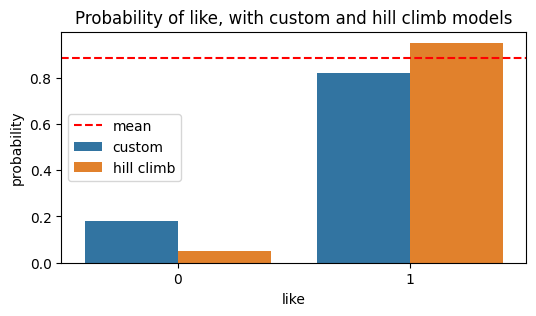

In [ ]:
name="Time"
artist="Pink Floyd"
inference(name, artist)

I've experimented with different songs not included in the dataset, and the models provide good estimates most of the time.<br>
When trying to inference without considering the genre, the results are not as good, but still fairly accurate. Sometimes (especially for pop songs), not considering the genre leads to totally different results, which shows that the model is biased (as I am) with respect to this feature.

## <b>6. Conclusion</b> <a class="anchor" id="6-conclusion"></a>
The final models are simplistic (also due to the discretization and naive assumptions when building the dataset), but they still provided interesting insights on relationships between features. Experimenting with bayesian network learning was useful to understand the pros and cons of these methods.<br>
The model I have built may represent correctly my personal musical tastes, but it might not perform as well with someone else's music data: the causal relationships I have modeled are based on my preferences, which are mostly _subjective_ (i.e. some people might not care as much about genre, or only like happy songs, making the existing causal links not valid).
The same thing can be said about the hill-climb model: it was generated by looking exclusively at my data, so it probably cannot generalize well with other people. Besides, this model could not even work with myself in the future, as musical taste can change over time.

Experimenting with Bayesian Networks offered insights for advantages and disadvantages of each method. Additionally, building the dataset from scartch was useful to better understand the data, and really helped in the process of designing the causal network.

# References <a class="anchor" id="references"></a>
1. [Spotify API documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)
2. [PGMpy Sampling source code](https://pgmpy.org/_modules/pgmpy/models/BayesianNetwork.html#BayesianNetwork.simulate)
3. [PGMpy rejection sampling source code](https://pgmpy.org/_modules/pgmpy/sampling/Sampling.html#BayesianModelSampling.rejection_sample)
